# Chapter 9 Homework Answers

In [3]:
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
from watermark import watermark

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-07-03T17:15:35.317981-04:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.17.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [5]:
watermark --iversions

NameError: name 'iversions' is not defined

# 9E1 
Which of the following is a requirement of the simple Metropolis algorithm?
1. The parameters must be discrete.
2. The likelihood function must be Gaussian.
3. The proposal distribution must be symmetric.
9E2. Gibbs sampling is more efficient than the Metropolis algorithm. How does it achieve this extra
efficiency? Are there any limitations to the Gibbs sampling strategy?
9.7. PRACTICE 297
9E3. Which sort of parameters can Hamiltonian Monte Carlo not handle? Can you explain why?
9E4. Explain the difference between the effective number of samples, n_eff as calculated by Stan,
and the actual number of samples.
9E5. Which value should Rhat approach, when a chain is sampling the posterior distribution correctly

9E1.
3 is required - the proposal distribution must be symmetric

9E2. Gibbs sample is more efficient than Metropolis because it uses better sampling methods (e.g. conjugate priors), so it needs fewer samples to get a good idea of the distribution.  However, both Metropolis and Gibbs sampling struggle with high dimentions, highly correlated parameter, and Gibbs sampling can have issues when there is not a conjugate prior/analytics solution to the posterior. 

9E3. HMC requires continuous paramters.  So if you are using discrete paramaters, some changes in coding are required.

9E4.  The number of samples is the number of draws from the posterior.  The posterior sames are autocorrelated, so the number of uncorrelated samples is the number of effective samples.  Typically the number of effective samples will be lower or the same as the number of samples.  However,  Since Stan and HMC can be efficient, sometimes the effective number of samples is higher than the samples 

9E5.  It should approach one.  Bad chains have rhat > 1

9E6/9E7 (drawn by hand)

In [10]:
#9M1
rugged_data_raw = pd.read_csv('Rethinking_2/End_of_chapter_problems/data/rugged.csv', sep=';')

rugged_data_raw["log_gdp"] = np.log(rugged_data_raw["rgdppc_2000"])

rugged_data = rugged_data_raw.dropna(subset=["log_gdp"])
rugged_data["log_gdp_std"] = rugged_data["log_gdp"] / rugged_data["log_gdp"].mean()
rugged_data["rugged_std"] = rugged_data["rugged"] / rugged_data["rugged"].max()

C:\Users\z003ucjz\AppData\Local\Temp\ipykernel_6948\1501565257.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rugged_data["log_gdp_std"] = rugged_data["log_gdp"] / rugged_data["log_gdp"].mean()
C:\Users\z003ucjz\AppData\Local\Temp\ipykernel_6948\1501565257.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rugged_data["rugged_std"] = rugged_data["rugged"] / rugged_data["rugged"].max()


In [36]:
cid = pd.Categorical(rugged_data["cont_africa"])

with pm.Model() as m_9m1_a:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[np.array(cid)] + b[np.array(cid)] * (rugged_data["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=rugged_data["log_gdp_std"].values)

    m_9m1_a_trace = pm.sample(chains=4,return_inferencedata=True)

with pm.Model() as m_9m1_b:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[np.array(cid)] + b[np.array(cid)] * (rugged_data["rugged_std"].values - 0.215)
    sigma = pm.Uniform('sigma',0,1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=rugged_data["log_gdp_std"].values)

    m_9m1_b_trace = pm.sample(chains=4,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


<Axes: title={'center': 'sigma'}>

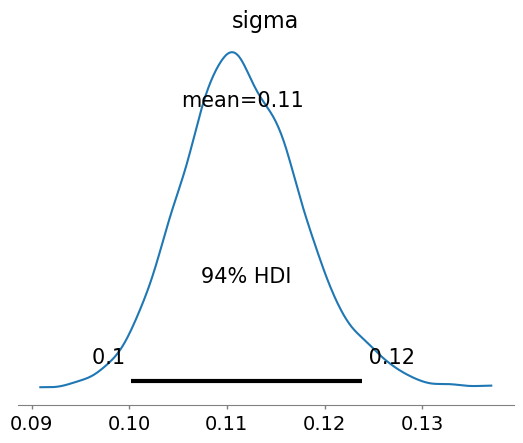

In [37]:
az.plot_posterior(m_9m1_a_trace,var_names='sigma')

<Axes: title={'center': 'sigma'}>

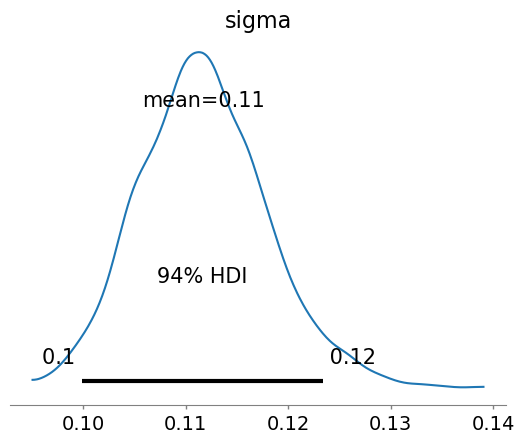

In [38]:
az.plot_posterior(m_9m1_b_trace,var_names='sigma')

The parameter estimates look fairly identical

In [41]:
#9M2
with pm.Model() as m_9m2:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Exponential("b", 0.3, shape=cid.categories.size)

    mu = a[np.array(cid)] + b[np.array(cid)] * (rugged_data["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=rugged_data["log_gdp_std"].values)

    m_9m2_trace = pm.sample(chains=4,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


In [54]:
az.summary(m_9m2_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.048,0.011,1.028,1.068,0.000,0.000,3894.0,2392.0,1.0
a[1],0.885,0.017,0.853,0.916,0.000,0.000,3666.0,2584.0,1.0
b[0],0.018,0.017,0.000,0.048,0.000,0.000,2250.0,1428.0,1.0
b[1],0.147,0.072,0.011,0.273,0.001,0.001,2446.0,1117.0,1.0
sigma,0.114,0.006,0.103,0.126,0.000,0.000,3200.0,2398.0,1.0


array([<Axes: title={'center': 'b\n0'}>, <Axes: title={'center': 'b\n1'}>],
      dtype=object)

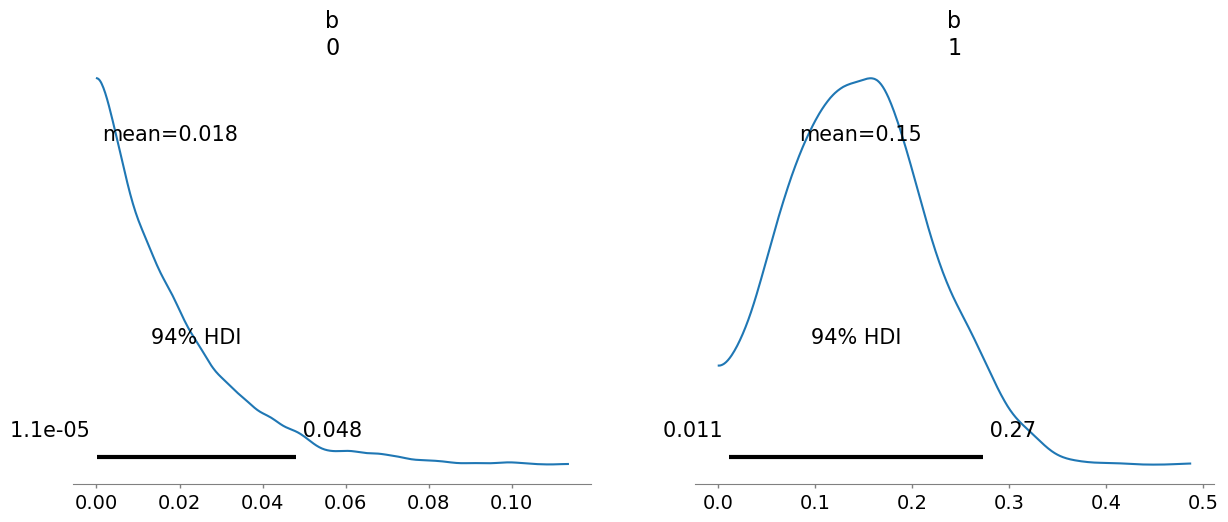

In [45]:
az.plot_posterior(m_9m2_trace,var_names='b')

array([<Axes: title={'center': 'b\n0'}>, <Axes: title={'center': 'b\n1'}>],
      dtype=object)

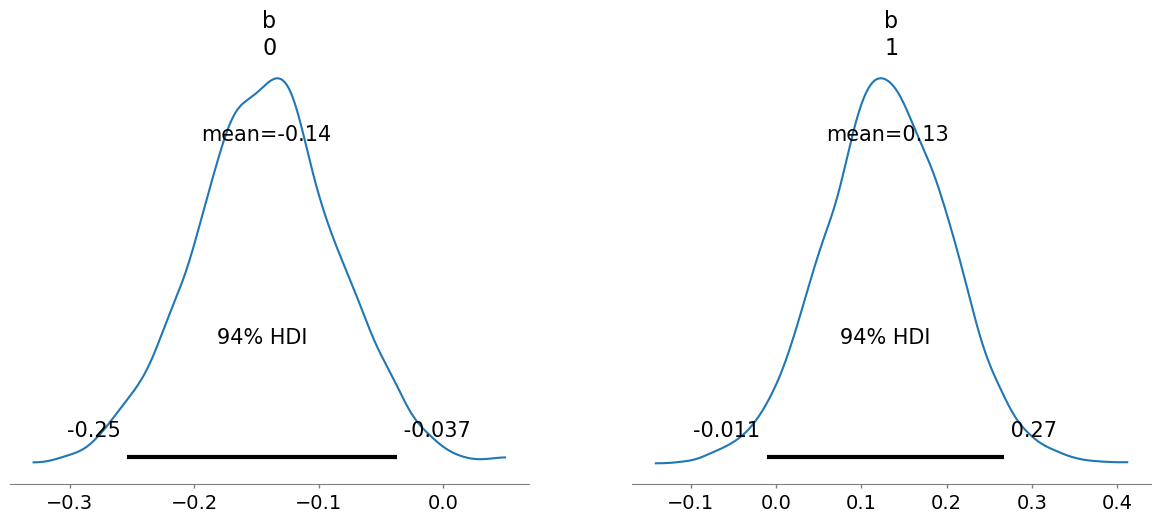

In [56]:
az.plot_posterior(m_9m1_a_trace,var_names='b')

The exponential distribution basically forces all values to be above zero.  But if we look at the original model, almost the entire distribution of b0 is below zero.  So you can see the effect where b0 is changed a lot and the distribution is forced to 0.  But for b1, the left side of the distribution cuts off at zero, but is still closer to the b0 of the original model.

In [57]:
#9M3

In [98]:
warmup_steps = [50,100,150,200,300,400,500,1000,1500]
m_9m3_traces = {}


with pm.Model() as m_9m3:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)
    mu = a[np.array(cid)] + b[np.array(cid)] * (rugged_data["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)
    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=rugged_data["log_gdp_std"].values)

with m_9m3:
    for step in warmup_steps: 
        m_9m3_trace = pm.sample(chains=4,return_inferencedata=True, tune = step)
        m_9m3_traces[step] = m_9m3_trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 34 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 33 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 150 tune and 1_000 draw iterations (600 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 400 tune and 1_000 draw iterations (1_600 + 4_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 33 seconds.


In [104]:
for value, step in enumerate(m_9m3_traces):
    if value == 0:
        m_9m3_steps_bulk = pd.DataFrame(az.summary(m_9m3_traces[step])['ess_bulk']).rename(columns={'ess_bulk':step})
    else:
        m_9m3_steps_bulk = m_9m3_steps_bulk.join(pd.DataFrame(az.summary(m_9m3_traces[step])['ess_bulk']).rename(columns={'ess_bulk':step}))
m_9m3_steps_df

,50,100,150,200,300,400,500,1000,1500
a[0],4301.0,4222.0,3348.0,4836.0,4220.0,4726.0,4563.0,6784.0,7501.0
a[1],4093.0,4363.0,3416.0,4857.0,4385.0,4889.0,4716.0,4986.0,5569.0
b[0],2815.0,2616.0,2906.0,5356.0,4659.0,5140.0,5540.0,4509.0,5649.0
b[1],1757.0,1509.0,4151.0,5408.0,3935.0,4984.0,5585.0,5116.0,6066.0
sigma,2921.0,2596.0,3936.0,5458.0,4224.0,5748.0,5056.0,6033.0,5875.0


In [108]:
for value, step in enumerate(m_9m3_traces):
    if value == 0:
        m_9m3_steps_tail = pd.DataFrame(az.summary(m_9m3_traces[step])['ess_tail']).rename(columns={'ess_tail':step})
    else:
        m_9m3_steps_tail = m_9m3_steps_tail.join(pd.DataFrame(az.summary(m_9m3_traces[step])['ess_tail']).rename(columns={'ess_tail':step}))
m_9m3_steps_df

,50,100,150,200,300,400,500,1000,1500
a[0],4301.0,4222.0,3348.0,4836.0,4220.0,4726.0,4563.0,6784.0,7501.0
a[1],4093.0,4363.0,3416.0,4857.0,4385.0,4889.0,4716.0,4986.0,5569.0
b[0],2815.0,2616.0,2906.0,5356.0,4659.0,5140.0,5540.0,4509.0,5649.0
b[1],1757.0,1509.0,4151.0,5408.0,3935.0,4984.0,5585.0,5116.0,6066.0
sigma,2921.0,2596.0,3936.0,5458.0,4224.0,5748.0,5056.0,6033.0,5875.0


Text(0.5, 1.0, 'Tail Samples')

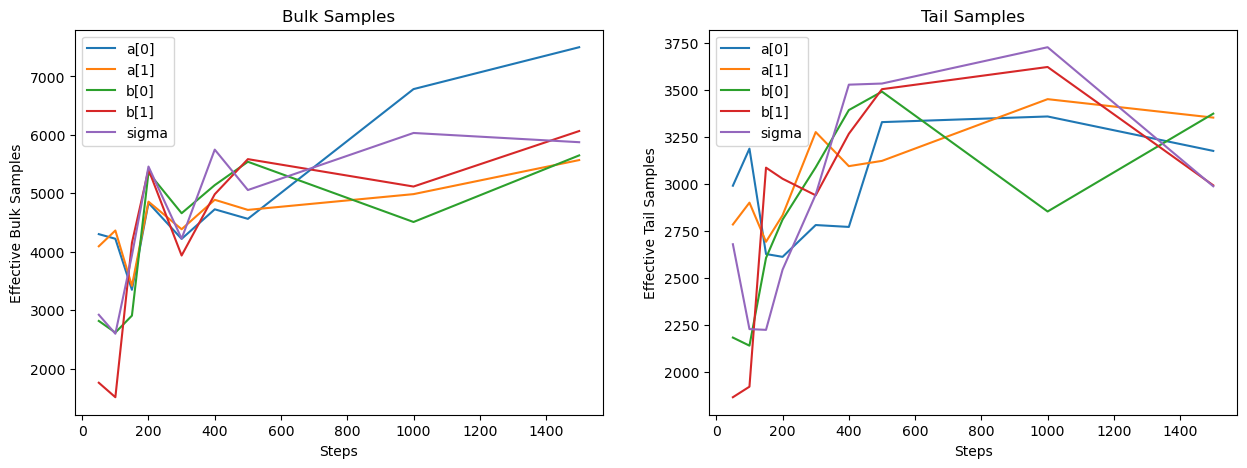

In [121]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
m_9m3_steps_bulk.T.plot(ax = ax[0])
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Effective Bulk Samples')
ax[0].set_title('Bulk Samples')

m_9m3_steps_tail.T.plot(ax = ax[1])
ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Effective Tail Samples')
ax[1].set_title('Tail Samples')

For the most part, it looks like the effective number of samples starts stabilizing fairly quickly, by 500 steps or so.  

In [143]:
#9H1
with pm.Model() as m_9h1:
    a = pm.Normal("a", 0, 1)
    b = pm.Cauchy("b", 0, 1)
    #y = 1
    m_9h1_trace = pm.sample(chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [a, b]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

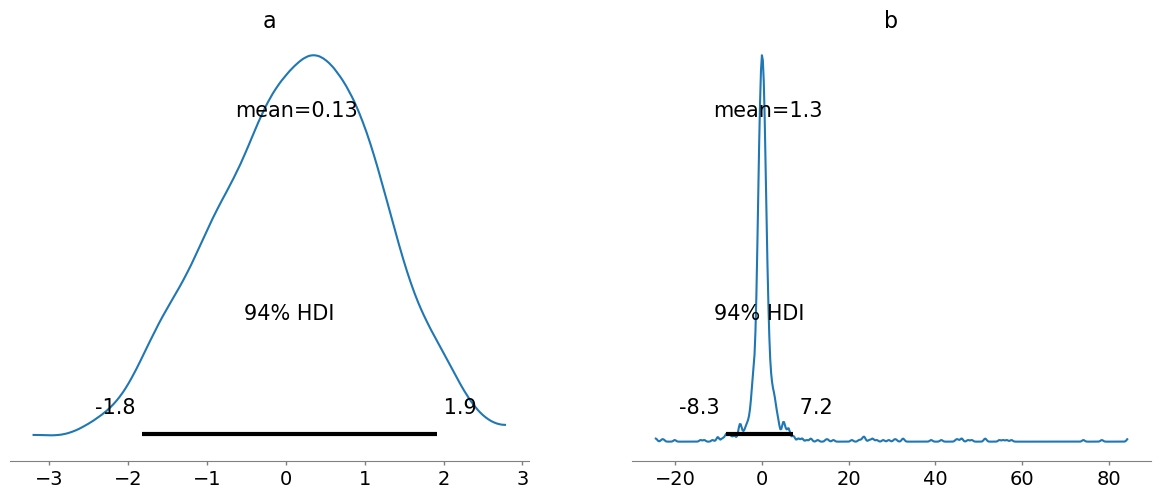

In [144]:
az.plot_posterior(m_9h1_trace)

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

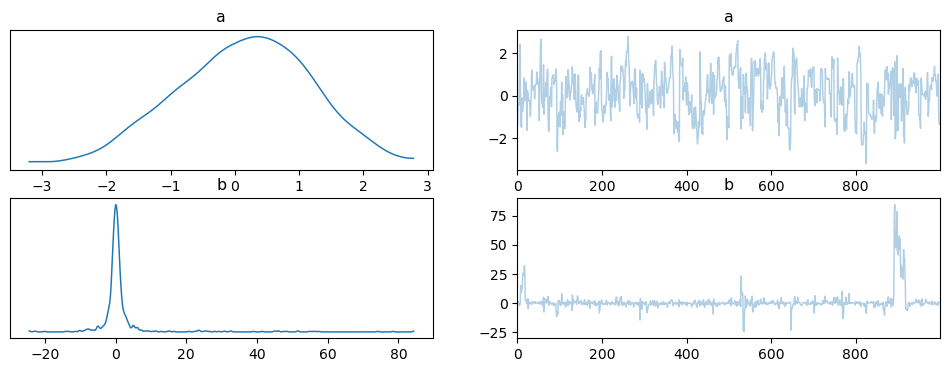

In [145]:
az.plot_trace(m_9h1_trace)

Given that the cauchy distribution seems to basically be a spike at a certain value and low density everwhere else, one would assume the trace will not wander around a lot because the majority of samples are going to be very close to each other, with some extreme values if it samples from the tails

In [146]:
#9H2

In [149]:
# yoink the data
divorce_data = pd.read_csv("./Rethinking_2/End_of_chapter_problems/data/WaffleDivorce.csv", delimiter=";")  # load waffle data

In [155]:
# scale all of the data
divorce_data['marriage_std'] = (divorce_data['Marriage'] - np.mean(divorce_data['Marriage'])) / np.std(divorce_data['Marriage'])
divorce_data['age_std'] = (divorce_data['MedianAgeMarriage'] - np.mean(divorce_data['MedianAgeMarriage'])) / np.std(divorce_data['MedianAgeMarriage'])
divorce_data['divorce_std'] = (divorce_data['Divorce'] - np.mean(divorce_data['Divorce'])) / np.std(divorce_data['Divorce'])

In [162]:
# running a Age_divorce linear regression
with pm.Model() as m_9h2_a:
    alpha = pm.Normal("alpha", 0, 0.2)  # prior on alpha
    beta = pm.Normal("beta_A", 0, 0.5)  # prior on beta
    sigma = pm.Exponential("sigma", 1)  # prior on sigma
    mu = alpha + beta * divorce_data['age_std']
    Divorce = pm.Normal("Divorce", mu=mu, sigma=sigma, observed=divorce_data['divorce_std'])  # likelihood of the data
    # 1000 random samples on 4 chains
    m_9h2_a_trace = pm.sample(idata_kwargs={"log_likelihood": True})


with pm.Model() as m_9h2_b:
    alpha = pm.Normal("alpha", 0, 0.2)  # prior on alpha
    beta = pm.Normal("beta_M", 0, 0.2)  # prior on beta
    sigma = pm.Exponential("sigma", 1)  # prior on sigma
    mu = alpha + beta * divorce_data['marriage_std']
    Divorce = pm.Normal("Divorce", mu=mu, sigma=sigma, observed=divorce_data['divorce_std'])  # likelihood of the data
    # 1000 random samples on 4 chains
    m_9h2_b_trace = pm.sample(idata_kwargs={"log_likelihood": True})


with pm.Model() as m_9h2_c:
    alpha = pm.Normal("alpha", 0, 0.2)  # prior on alpha
    beta = pm.Normal("beta_M", 0, 0.5, shape=2)  # prior on beta terms
    sigma = pm.Exponential("sigma", 1)  # prior on sigma
    mu = alpha + beta[0] * divorce_data['age_std'] + beta[1] * divorce_data['marriage_std']
    Divorce = pm.Normal("Divorce", mu=mu, sigma=sigma, observed=divorce_data['divorce_std'])  # likelihood of the data
    # 1000 random samples on 4 chains
    m_9h2_c_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [179]:
compare_9h2 = {"Age": m_9h2_a_trace, "Marriage": m_9h2_b_trace, "Age and Marraige": m_9h2_c_trace}
az.compare(compare_9h2, ic='loo',scale='deviance')

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Age,0,127.073505,3.822415,0.000000,0.89186,12.780809,0.000000,False,deviance
Age and Marraige,1,129.091116,4.981385,2.017611,0.00000,12.909658,0.654609,False,deviance
Marriage,2,140.457374,2.551669,13.383869,0.10814,9.233137,9.776490,False,deviance


It looks like the model without Age as a predictor is clearly worse than the other two with Age.  Note that in the textbook, I think this assumes this is the first time we ar eusing HMC.  However, since we are using PYMC and not the textbook functions (e.g. ulam), we have always been using HMC.  So this howework exercise proably doesn't have the learning effect it was orignally meant to.

## 9H3

In [194]:
N = 100  
height_data = np.random.normal(10, 2, N)  
leg_prop = np.random.uniform(0.4, 0.5, N) 
left_leg = leg_prop * height_data + np.random.normal(0, 0.02, N) 
right_leg = leg_prop * height_data + np.random.normal(0, 0.02, N) 


with pm.Model() as m_9h3_a:
    alpha = pm.Normal("alpha", 10, 100)  # prior on alpha
    bl = pm.Normal("bl", 2, 10)  # prior on beta
    br = pm.Normal("br", 2, 10)  # prior on beta
    sigma = pm.Exponential("sigma", 1)  # prior on sigma
    mu = alpha + bl*left_leg + br*right_leg
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=height_data) 
    m_9h3_a_trace = pm.sample(chains = 4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bl, br, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 216 seconds.


In [204]:
with pm.Model() as m_9h3_b:
    alpha = pm.Normal("alpha", 10, 100)  
    bl = pm.Normal("bl", 2, 10)
    br = pm.TruncatedNormal('br', mu=2, sigma=10, lower=0)
    sigma = pm.Exponential("sigma", 1) 
    mu = alpha + bl*left_leg + br*right_leg
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=height_data) 
    m_9h3_b_trace = pm.sample(chains = 4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bl, br, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 741 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'bl'}>,
       <Axes: title={'center': 'br'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

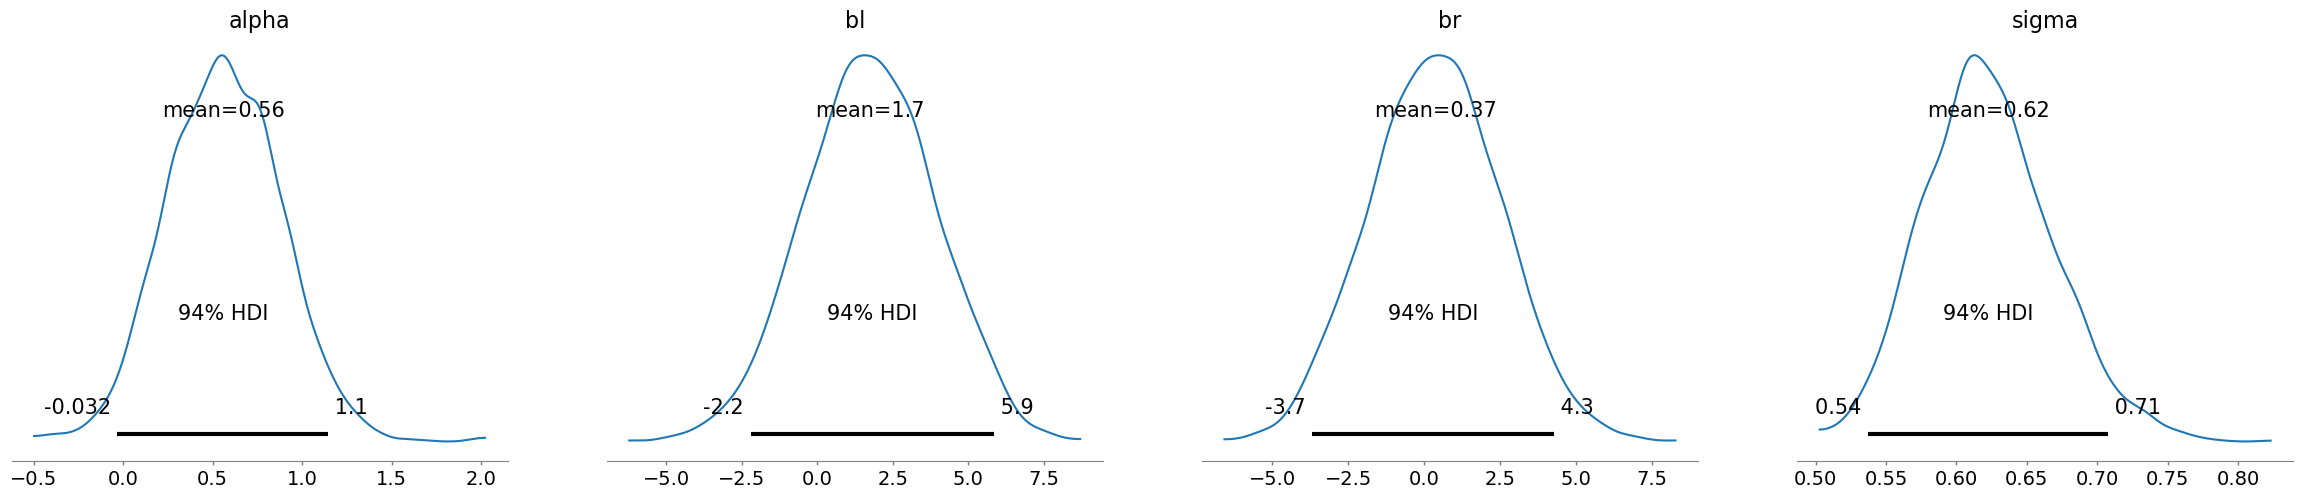

In [205]:
az.plot_posterior(m_9h3_a_trace)

array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'bl'}>,
       <Axes: title={'center': 'br'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

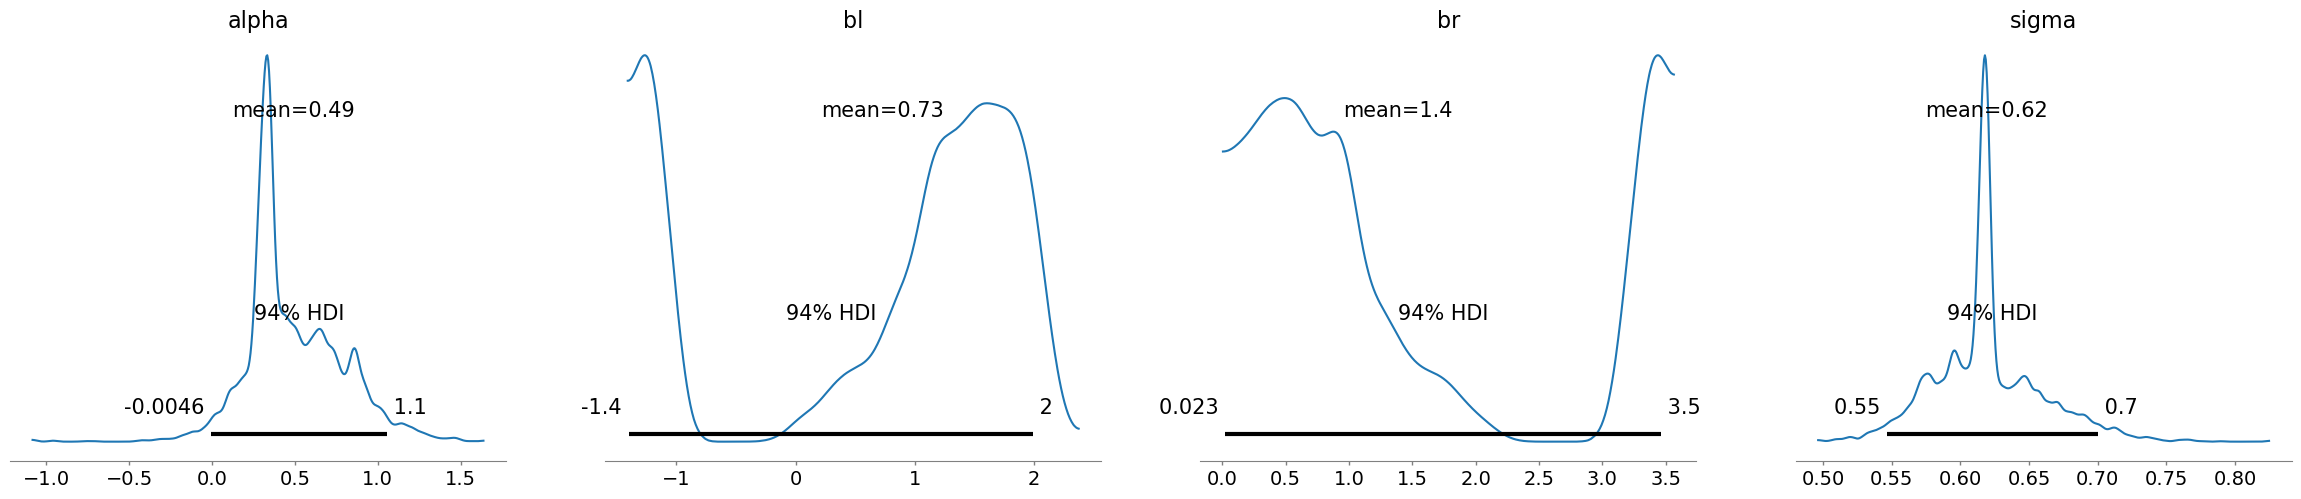

In [206]:
az.plot_posterior(m_9h3_b_trace)

For the model with the constrained br, it looks like bl and br are generally mirroring each other.  So basically, in order to maintain the relationship between bl and br (which are both identially correlated with height), bl has changed to match the change in br.